In [ ]:
import numpy as np
import pandas as pd

from google.colab import drive

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams["figure.dpi"] = 140
figure(figsize=(16, 9), dpi=140)

#from tqdm import tqdm
#tqdm.pandas()

In [ ]:
# Monta Google Drive
drive.mount('/content/drive')

In [4]:
# Load the Database

base_path = '/content/drive/MyDrive/POC-TDC/data/'

df = pd.read_pickle(base_path + 'training_data.pkl')

# Only the damaged/undamaged cases are of interrest
df = df[df['y'] < 2.0]

print(df.shape)
print(df.y.value_counts())
df.tail(5)

(175, 2049)
0.0    97
1.0    78
Name: y, dtype: int64


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,y
189,0.011588,0.542743,0.237054,0.000000,0.169860,0.139769,0.029060,0.000000,0.006840,0.002890,0.011518,0.068702,0.055173,0.036566,0.134998,0.035995,0.117843,0.525772,0.181600,0.058684,0.004378,0.340131,0.009906,0.005649,0.000000,0.072987,0.121938,0.380542,0.017991,0.019340,0.383089,0.278048,0.030502,0.336248,0.082564,0.013858,0.041835,0.000000,0.115547,0.000000,...,0.151296,0.000788,0.002853,0.323073,0.022234,0.256832,0.132960,0.000000,0.004277,0.0,0.000000,0.000000,0.461035,0.048639,0.002255,0.000000,0.045826,0.016465,0.448239,0.081846,0.072585,0.080903,0.031614,0.197493,0.331914,0.010492,0.657367,0.096777,0.000000,0.167879,0.014073,0.264419,0.000000,0.000000,0.000000,0.298781,0.491518,0.0,0.000000,0.0
190,0.215159,0.066617,0.009473,0.033345,0.100871,0.333629,0.273450,0.001818,0.023533,0.005646,0.071296,0.204064,0.077571,0.037671,0.224417,0.051562,0.083572,0.449704,0.533434,0.000000,0.072091,0.172787,0.237951,0.000000,0.012415,0.125939,0.266586,0.414338,0.113821,0.031715,0.255955,0.243345,0.000000,0.345285,0.234663,0.006833,0.000000,0.105678,0.015402,0.006000,...,0.012596,0.103130,0.022068,0.347636,0.001231,0.372424,0.421985,0.009695,0.053592,0.0,0.220748,0.005904,0.421442,0.487226,0.019744,0.277387,0.052321,0.018961,0.964340,0.201956,0.079670,0.041668,0.182964,0.000797,0.334369,0.007843,0.282984,0.237134,0.052176,0.028251,0.000023,0.160934,0.030825,0.201865,0.034622,0.169971,0.237959,0.0,0.036272,1.0
191,0.000540,0.359868,0.168028,0.183052,0.420273,0.227327,0.332934,0.065714,0.086991,0.002134,0.000545,0.229841,0.400833,0.035801,0.180181,0.064218,0.439678,0.222189,0.088188,0.073212,0.009329,0.528619,0.057908,0.014972,0.000000,0.090724,0.064712,0.000000,0.006444,0.000000,0.378498,0.316419,0.150269,0.483117,0.314305,0.004514,0.029742,0.000889,0.004420,0.000452,...,0.000000,0.217503,0.000000,0.390345,0.000000,0.314822,0.343964,0.095804,0.110121,0.0,0.000000,0.006178,0.348848,0.299529,0.000000,0.000000,0.102804,0.051310,0.676601,0.053911,0.000000,0.089695,0.001220,0.078198,0.069996,0.002574,0.404706,0.044726,0.000000,0.000777,0.089080,0.166774,0.000000,0.001136,0.185041,0.105678,0.332034,0.0,0.008962,1.0
192,0.006860,0.386583,0.000596,0.117336,0.006011,0.269852,0.197263,0.006883,0.000000,0.000000,0.002333,0.017997,0.189993,0.013944,0.001355,0.000000,0.272652,0.480024,0.732456,0.055264,0.000000,0.011803,0.142239,0.002792,0.000000,0.000000,0.093895,0.136619,0.141679,0.014544,0.003368,0.202863,0.000000,0.316291,0.426273,0.000459,0.000000,0.025166,0.000000,0.000000,...,0.007997,0.000762,0.034512,0.199483,0.000073,0.301647,0.245266,0.138371,0.000534,0.0,0.000000,0.000000,0.090209,0.068692,0.000482,0.000000,0.021399,0.132728,0.595241,0.021397,0.000000,0.094820,0.015112,0.027977,0.357644,0.001981,0.583603,0.000000,0.060557,0.000000,0.065808,0.000000,0.000000,0.055356,0.000000,0.193627,0.046464,0.0,0.000000,1.0
193,0.000000,0.303475,0.000000,0.000000,0.034496,0.005790,0.087050,0.001132,0.000000,0.000000,0.000000,0.001139,0.301607,0.000000,0.013433,0.193930,0.219479,1.494890,0.000000,0.000000,0.000000,0.522612,0.254689,0.000000,0.000000,0.000000,0.058361,0.061002,0.000000,0.037642,0.011649,0.225312,0.359460,0.247867,0.067187,0.000000,0.000240,0.000000,0.073268,0.000000,...,0.000000,0.300399,0.000241,0.344153,0.000470,0.279733,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.032237,0.151063,0.032212,0.000000,0.011757,0.000000,0.607792,0.147637,0.000000,0.211702,0.000000,0.000000,0.198992,0.000000,0.505871,0.000000,0.000000,0.000000,0.000000,0.001404,0.000000,0.100194,0.009781,0.090588,0.066749,0.0,0.017178,1.0


In [ ]:
# Single Train/Test
SEED = 2112

y = df.y.values
#y = df.y.values.reshape(-1,1)
X = df.drop('y', axis=1).values

x_train, x_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.3333, 
    random_state=SEED
)

print('Original Data:     {:03d}'.format(len(df)))
print('Training Data (A): {:03d}'.format(len((x_train))))
print('Testing Data  (B): {:03d}'.format(len(x_test)))
print('Total Size  (A+B): {:03d}'.format(len(x_train) + len(x_test)))

Original Data:     175
Training Data (A): 116
Testing Data  (B): 059
Total Size  (A+B): 175


# Training Time (Finally)

In [ ]:
# Models to be Used

classifiers = [
    ("Neural Network", MLPClassifier(max_iter=1000, hidden_layer_sizes=(2048) )),
    ("Linear SVM", SVC(kernel="linear", C=0.025)),
    ("Nearest Neighbors", KNeighborsClassifier(5)),
    ("RBF SVM", SVC(gamma=2, C=1)),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Random Forest", RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight="balanced") ),
    ("Adaboost", AdaBoostClassifier()),
    ("Naive Bayes", GaussianNB()),
    ("QDA", QuadraticDiscriminantAnalysis()),
]


Training for Neural Network
0.9558823529411764

Training for Linear SVM
0.9428571428571428

Training for Nearest Neighbors
0.8163265306122449

Training for RBF SVM
0.7719298245614035

Training for Decision Tree
0.8023809523809524

Training for Random Forest
0.9078947368421053

Training for Adaboost
0.9428571428571428

Training for Naive Bayes
0.9305555555555556

Training for QDA
0.6713836477987422

Best Classifier: ('Neural Network', 0.6, 0.9558823529411764, 0.9464285714285714, 0.9486211901306242, array([31, 28]))


/usr/local/lib/python3.7/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


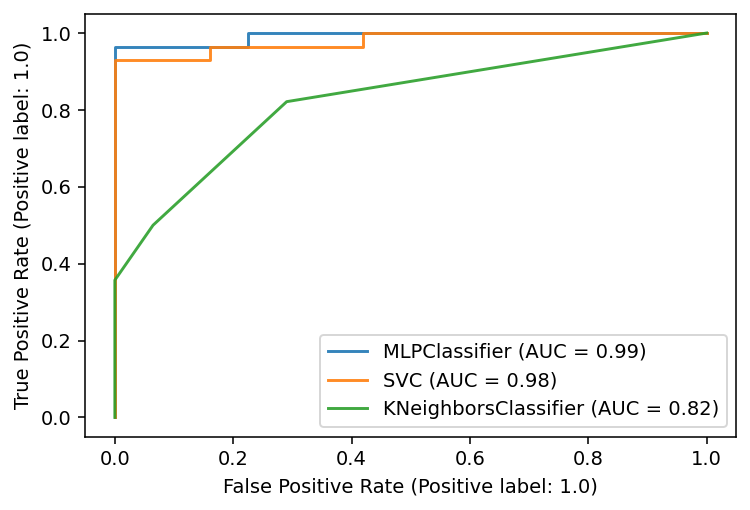

In [ ]:
# iterate over classifiers

ax = plt.gca()

scores = []
disp = []
best = ('None', 0.0, 0.0, 0.0, 0.0)

for name, clf in classifiers:

    print('Training for', name)
    clf.fit(x_train, y_train)

    y_pred = clf.predict(x_test)
    pr, rc, f1, sp = precision_recall_fscore_support(y_test, y_pred, average='macro')
    sp = np.sum(confusion_matrix(y_test, y_pred), axis=1)
    scores.append((name, pr, rc, f1, sp))
    
    if len(scores) < 4:
        disp.append(RocCurveDisplay.from_estimator(clf, x_test, y_test, ax=ax, alpha=0.9))

    print(pr)
    print('')

    # Compare the precisions
    if score > best[2]:
        best = (name,score, pr, rc, f1, sp)

print('Best Classifier:', best)

In [ ]:
df_results = pd.DataFrame(scores, columns=['Name', 'Precision', 'Recall', 'F1', 'Support'])

df_results.sort_values('F1', ascending=False).head(10)

,Name,Precision,Recall,F1,Support
0,Neural Network,0.955882,0.946429,0.948621,"[31, 28]"
1,Linear SVM,0.942857,0.928571,0.931235,"[31, 28]"
6,Adaboost,0.942857,0.928571,0.931235,"[31, 28]"
7,Naive Bayes,0.930556,0.910714,0.913667,"[31, 28]"
5,Random Forest,0.918919,0.892857,0.895882,"[31, 28]"
4,Decision Tree,0.782353,0.776498,0.777358,"[31, 28]"
2,Nearest Neighbors,0.816327,0.678571,0.650658,"[31, 28]"
8,QDA,0.671384,0.562788,0.468468,"[31, 28]"
3,RBF SVM,0.771930,0.535714,0.418939,"[31, 28]"


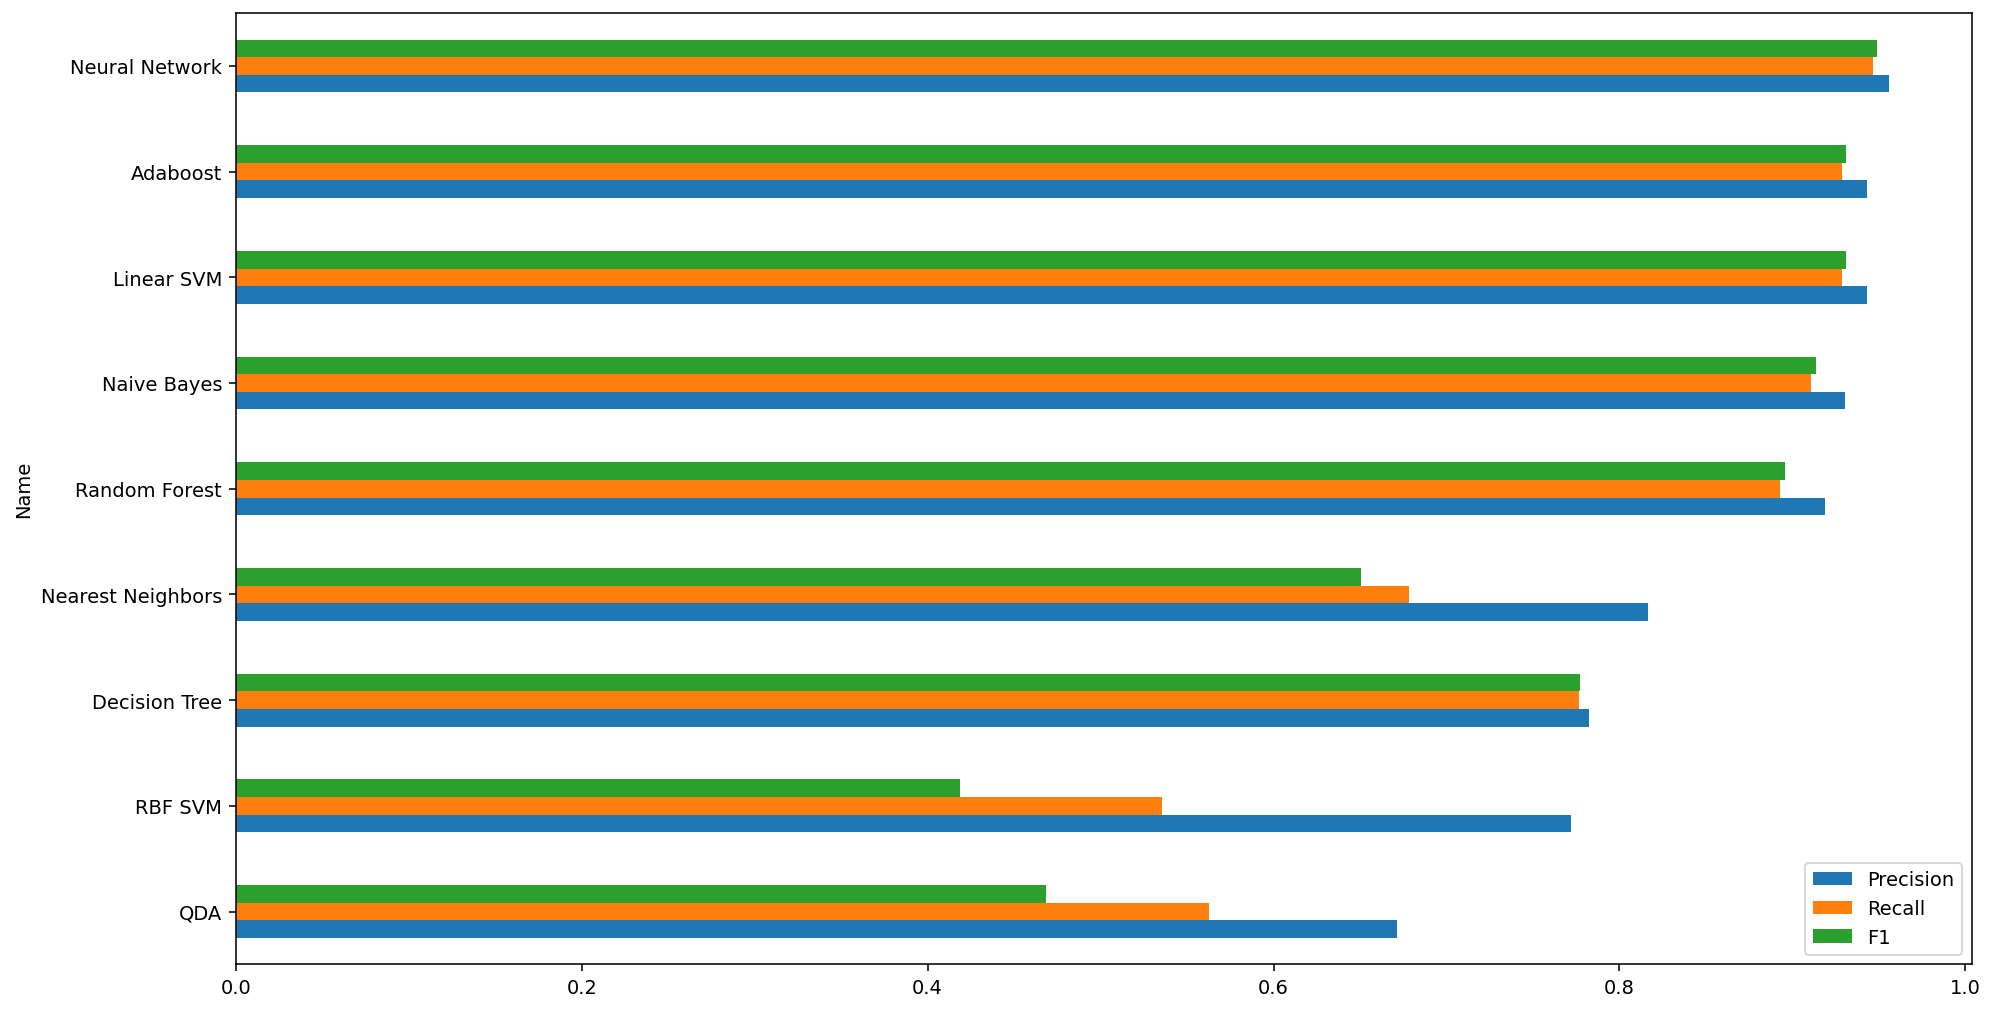

In [ ]:
plt.rcParams["figure.dpi"] = 140
df_results.set_index('Name').sort_values('Precision', ascending=True).plot.barh(figsize=(16,9))
